# About the Project

This project explores coordinate-based neural networks for image reconstruction. A fully connected multilayer perceptron is implemented from scratch using NumPy, where the input is a 2D pixel coordinate $(x,y)$and the output is the corresponding RGB color value $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

To investigate how the network captures spatial and frequency details, I compared several input feature mapping strategies $\gamma (\mathbf{v})$:

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$.

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$.

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$,
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathrm{N}(0, \sigma^2)$.

Implementation Highlights:

- Mappings are implemented in the helper functions `get_B_dict` and `input_mapping`.
- The basic mapping can be considered a case where $\mathbf B \in \mathbb R^{2 \times 2}$ is the indentity matrix.
- For this project, $d$ is 2 because the input coordinates in two dimensions.

## Setup

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
import os
datadir = "path/"
if not os.path.exists(datadir):
  !ln -s "path/" $datadir
os.chdir(datadir)
!pwd

### Imports

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio
import cv2
import numpy as np
from base64 import b64encode
from IPython.display import HTML

from models.neural_net import NeuralNetwork

# makes sure your NeuralNetwork updates as you make changes to the .py file
%load_ext autoreload
%autoreload 2

# sets default size of plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helper Functions

### Image Data and Feature Mappings

In [ ]:
# Data loader - already done for you
def get_image(size=512, \
              image_url='https://bmild.github.io/fourfeat/img/lion_orig.png'):

  # Download image, take a square crop from the center
  img = imageio.imread(image_url)[..., :3] / 255.
  c = [img.shape[0]//2, img.shape[1]//2]
  r = 256
  img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

  if size != 512:
    img = cv2.resize(img, (size, size))

  plt.imshow(img)
  plt.show()

  # Create input pixel coordinates in the unit square
  coords = np.linspace(0, 1, img.shape[0], endpoint=False)
  x_test = np.stack(np.meshgrid(coords, coords), -1)
  test_data = [x_test, img]
  train_data = [x_test[::2, ::2], img[::2, ::2]]

  return train_data, test_data

In [ ]:
# Create the mappings dictionary of matrix B -  you will implement this
def get_B_dict(size, scale = 1.0):
    mapping_size = size // 2
    # mapping_size = size (for extra credit)
    B_dict = {}
    B_dict['none'] = None

    # Basic mapping
    basic_mapping = np.eye(2)
    B_dict['basic'] = basic_mapping

    # Gaussian mapping
    gauss_mapping = np.random.normal(scale=scale, size = (mapping_size, 2))
    B_dict['gauss_1.0'] = gauss_mapping

    return B_dict

In [ ]:
# Given tensor x of input coordinates, map it using B
def input_mapping(x, B):
    if B is None:
        return x
    else:
        proj = 2 * np.pi * (x @ B.T)
        cos_term = np.cos(proj)
        sin_term = np.sin(proj)
        mapped_features = np.concatenate([cos_term, sin_term], axis=-1)
        return mapped_features

### MSE Loss and PSNR Error

In [ ]:
# Loss function and evaluation metric
def mse(y, p):
  return np.mean((y - p) ** 2)

def psnr(y, p):
  return -10 * np.log10(2.*mse(y, p))

/tmp/ipykernel_1671925/2979632171.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


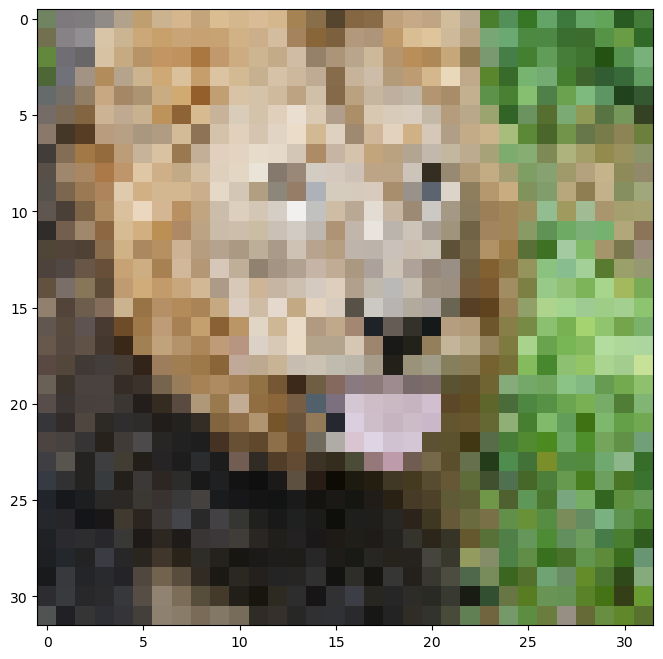

In [ ]:
# Display image
size = 32
train_data, test_data = get_image(size)

In [ ]:
# Set the hyperparameters
num_layers = 4

hidden_size = 256
epochs = 1000
learning_rate = 0.1
output_size = 3
B_dict = get_B_dict(size)

print('B_dict items:')
for k,v in B_dict.items():
    print('\t',k,np.array(v).shape)

B_dict items:
	 none ()
	 basic (2, 2)
	 gauss_1.0 (16, 2)


In [ ]:
# Apply the input feature mapping to the train and test data
def get_input_features(B_dict, mapping):
  # mapping is the key to the B_dict, which has the value of B
  # B is then used with the function `input_mapping` to map x
  y_train = train_data[1].reshape(-1, output_size)
  y_test = test_data[1].reshape(-1, output_size)
  X_train = input_mapping(train_data[0].reshape(-1, 2), B_dict[mapping])
  X_test = input_mapping(test_data[0].reshape(-1, 2), B_dict[mapping])
  return X_train, y_train, X_test, y_test

### Plotting and video helper functions

In [ ]:
def plot_training_curves(train_loss, train_psnr, test_psnr):
  # plot the training loss
  plt.subplot(2, 1, 1)
  plt.plot(train_loss)
  plt.title('MSE history')
  plt.xlabel('Iteration')
  plt.ylabel('MSE Loss')

  # plot the training and testing psnr
  plt.subplot(2, 1, 2)
  plt.plot(train_psnr, label='train')
  plt.plot(test_psnr, label='test')
  plt.title('PSNR history')
  plt.xlabel('Iteration')
  plt.ylabel('PSNR')
  plt.legend()

  plt.tight_layout()
  plt.show()

def plot_reconstruction(p, y):
  p_im = p.reshape(size,size,3)
  y_im = y.reshape(size,size,3)

  plt.figure(figsize=(12,6))

  # plot the reconstruction of the image
  plt.subplot(1,2,1), plt.imshow(p_im), plt.title("reconstruction")

  # plot the ground truth image
  plt.subplot(1,2,2), plt.imshow(y_im), plt.title("ground truth")

  print("Final Test MSE", mse(y, p))
  print("Final Test psnr",psnr(y, p))

def plot_reconstruction_progress(predicted_images, y, N=8):
  total = len(predicted_images)
  step = total // N
  plt.figure(figsize=(24, 4))

  # plot the progress of reconstructions
  for i, j in enumerate(range(0,total, step)):
      plt.subplot(1, N+1, i+1)
      plt.imshow(predicted_images[j].reshape(size,size,3))
      plt.axis("off")
      plt.title(f"iter {j}")

  # plot ground truth image
  plt.subplot(1, N+1, N+1)
  plt.imshow(y.reshape(size,size,3))
  plt.title('GT')
  plt.axis("off")
  plt.show()

def plot_feature_mapping_comparison(outputs, gt):
  # plot reconstruction images for each mapping
  plt.figure(figsize=(24, 4))
  N = len(outputs)
  for i, k in enumerate(outputs):
      plt.subplot(1, N+1, i+1)
      plt.imshow(outputs[k]['pred_imgs'][-1].reshape(size, size, -1))
      plt.title(k)
  plt.subplot(1, N+1, N+1)
  plt.imshow(gt)
  plt.title('GT')
  plt.show()

  # plot train/test error curves for each mapping
  iters = len(outputs[k]['train_psnrs'])
  plt.figure(figsize=(16, 6))
  plt.subplot(121)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['train_psnrs'], label=k)
  plt.title('Train error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.subplot(122)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['test_psnrs'], label=k)
  plt.title('Test error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.show()

# Save out video
def create_and_visualize_video(outputs, size=size, epochs=epochs, filename='training_convergence.mp4'):
  all_preds = np.concatenate([outputs[n]['pred_imgs'].reshape(epochs,size,size,3)[::25] for n in outputs], axis=-2)
  data8 = (255*np.clip(all_preds, 0, 1)).astype(np.uint8)
  f = os.path.join(filename)
  imageio.mimwrite(f, data8, fps=20)

  # Display video inline
  from IPython.display import HTML
  from base64 import b64encode
  mp4 = open(f, 'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

  N = len(outputs)
  if N == 1:
    return HTML(f'''
    <video width=256 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    ''')
  else:
    return HTML(f'''
    <video width=1000 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    <table width="1000" cellspacing="0" cellpadding="0">
      <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
      <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
    </table>
    '''.format(*list(outputs.keys())))

### Experiment Runner

In [ ]:
def NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, output_size, epochs,\
                  learning_rate, loss_function, opt='SGD', b1=0.9, b2=0.999, eps=1e-8,
                  batch_size = 32):

    # Initialize a new neural network model
    hidden_sizes = [hidden_size] * (num_layers - 1)
    current_lr = learning_rate
    net = NeuralNetwork(input_size, hidden_sizes, output_size, num_layers, opt, loss_function)

    # Variables to store performance for each epoch
    train_loss = np.zeros(epochs)
    train_psnr = np.zeros(epochs)
    test_psnr = np.zeros(epochs)
    predicted_images = np.zeros((epochs, y_test.shape[0], y_test.shape[1]))

    # For each epoch...
    for epoch in tqdm(range(epochs)):
        # Shuffle the dataset
        idx = np.arange(X_train.shape[0])
        np.random.shuffle(idx)
        X_train_shuf = X_train[idx]
        y_train_shuf = y_train[idx]

        if opt == 'Adam':
          # 1. Forward pass
          y_pred_train = net.forward(X_train_shuf)
          # 2. Backward pass
          epoch_loss = net.backward(y_train_shuf)
          # 3. Update the weights
          net.update(lr=current_lr, b1=b1, b2=b2, eps=eps)

        elif opt == 'SGD': # mini-batch SGD
          num_train = X_train_shuf.shape[0]
          num_batches = (num_train + batch_size - 1) // batch_size
          epoch_loss = 0.0

          for b in range(num_batches):
              start = b * batch_size
              end = min(start + batch_size, num_train)
              X_batch = X_train_shuf[start:end]
              y_batch = y_train_shuf[start:end]

              # 1. Forward pass
              y_pred_train_batch = net.forward(X_batch)

              # 2. Backward pass
              train_loss_val = net.backward(y_batch)

              # 3. Update the weights
              net.update(lr=current_lr)

              epoch_loss += train_loss_val

          epoch_loss /= num_batches

        train_loss[epoch] = epoch_loss

        # Testing
        y_pred_train = net.forward(X_train)
        train_psnr[epoch] = psnr(y_train, y_pred_train)

        y_pred_test = net.forward(X_test)
        test_psnr[epoch] = psnr(y_test, y_pred_test)
        predicted_images[epoch] = y_pred_test.copy()

    return net, train_psnr, test_psnr, train_loss, predicted_images

# Low Resolution Reconstruction

#### Low Resolution Reconstruction - SGD - None Mapping

/tmp/ipykernel_1671925/2979632171.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


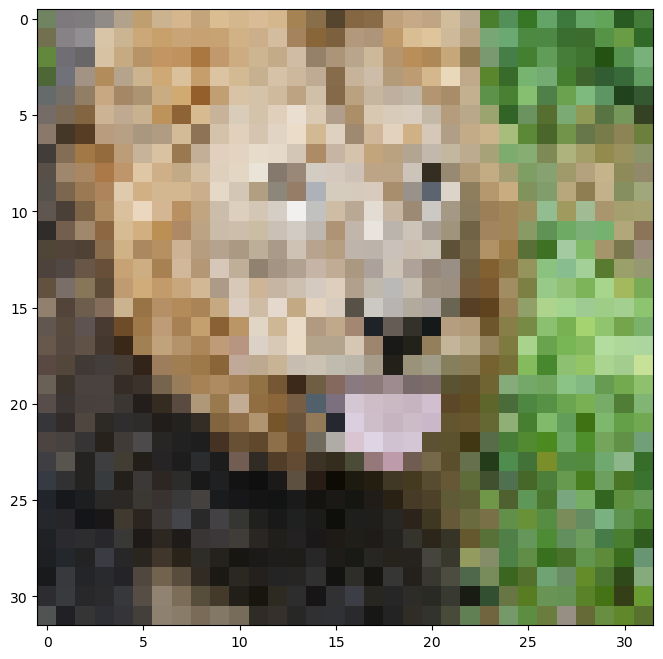

In [ ]:
# Display image
size = 32
train_data, test_data = get_image(size)

In [ ]:
B_dict = get_B_dict(size)

print('B_dict items:')
for k,v in B_dict.items():
    print('\t',k,np.array(v).shape)

B_dict items:
	 none ()
	 basic (2, 2)
	 gauss_1.0 (16, 2)


In [ ]:
# Set the hyperparameters
num_layers = 4
output_size = 3

# Adjust these
hidden_size = 256
epochs = 2000
learning_rate = 0.02

  0%|          | 0/2000 [00:00<?, ?it/s]

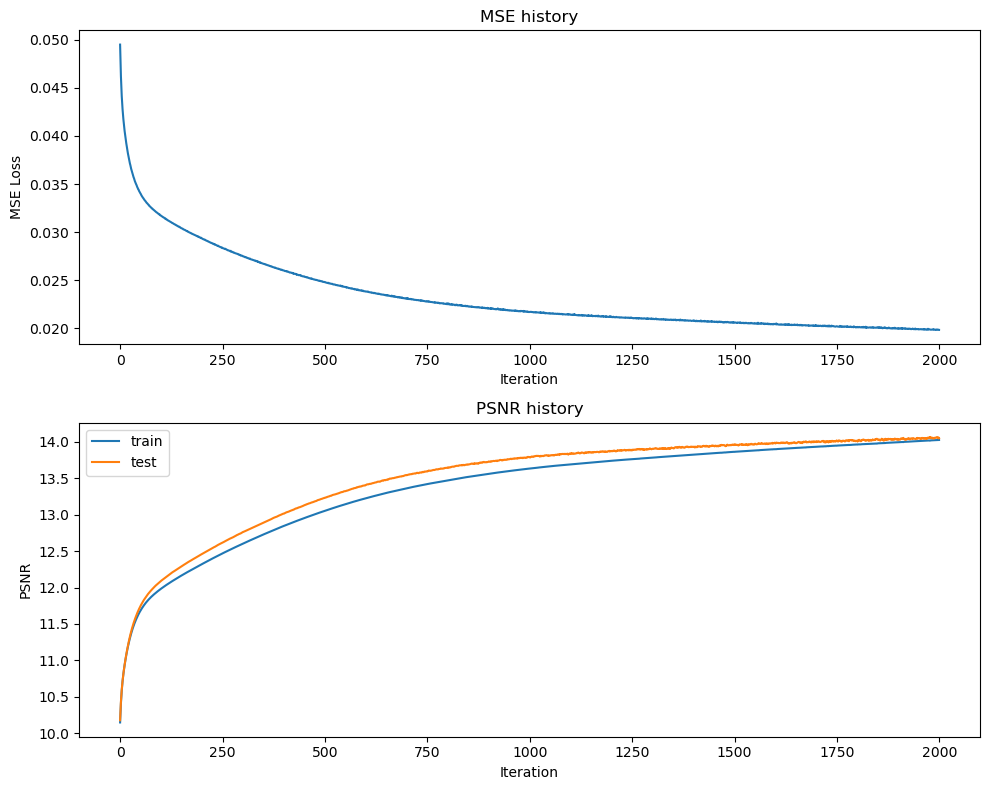

Final Test MSE 0.01968779947165195
Final Test psnr 14.047728270869522


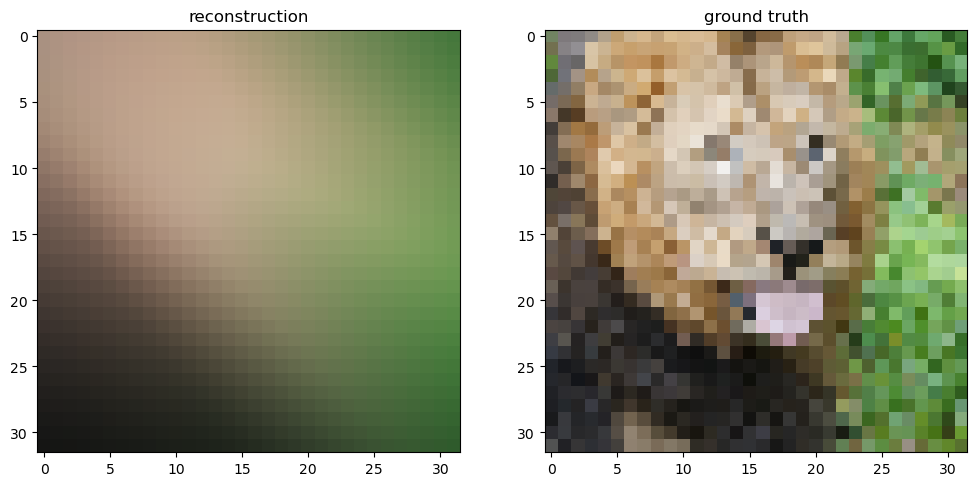

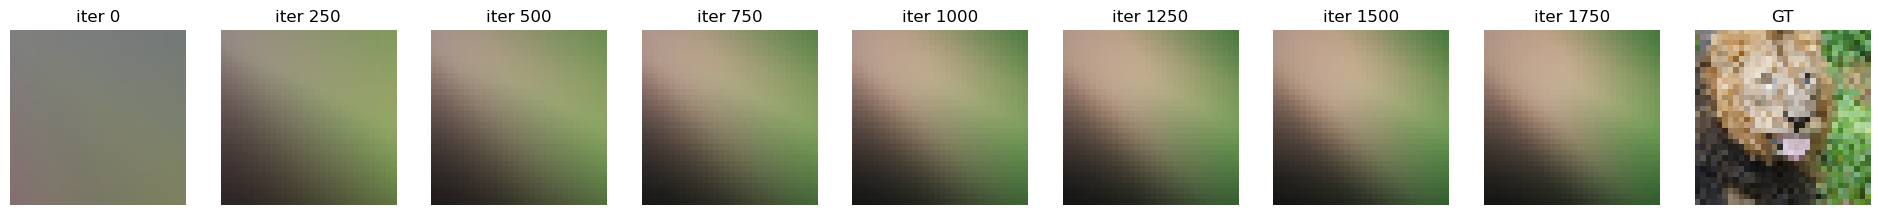

In [ ]:
# Get input features
B_dict = get_B_dict(size=512)
X_train, y_train, X_test, y_test = get_input_features(B_dict, mapping='none')
input_size = X_train.shape[1]

# Run NN experiment on input features
net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(
                    X_train, y_train, X_test, y_test, input_size, num_layers,
                    hidden_size, output_size, epochs, learning_rate, 'mse', opt="SGD",
                    batch_size=32)

# Plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - SGD - Various Input Mapping Stategies

In [ ]:
def train_wrapper(mapping, size, num_layers, hidden_size, output_size, epochs, learning_rate, loss_function, opt='SGD'):

    B_dict = get_B_dict(size)
    X_train, y_train, X_test, y_test = get_input_features(B_dict,mapping)
    input_size = X_train.shape[1]

    net, train_psnrs, test_psnrs, train_loss, predicted_images = NN_experiment(
                    X_train, y_train, X_test, y_test, input_size, num_layers,
                    hidden_size, output_size, epochs, learning_rate, loss_function, opt, batch_size=32)

    return {
        'net': net,
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'train_loss': train_loss,
        'pred_imgs': predicted_images
    }

In [ ]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size, num_layers, hidden_size, output_size, epochs, learning_rate, 'mse', opt='SGD')

  0%|          | 0/3 [00:00<?, ?it/s]

training none


  0%|          | 0/2000 [00:00<?, ?it/s]

training basic


  0%|          | 0/2000 [00:00<?, ?it/s]

training gauss_1.0


  0%|          | 0/2000 [00:00<?, ?it/s]

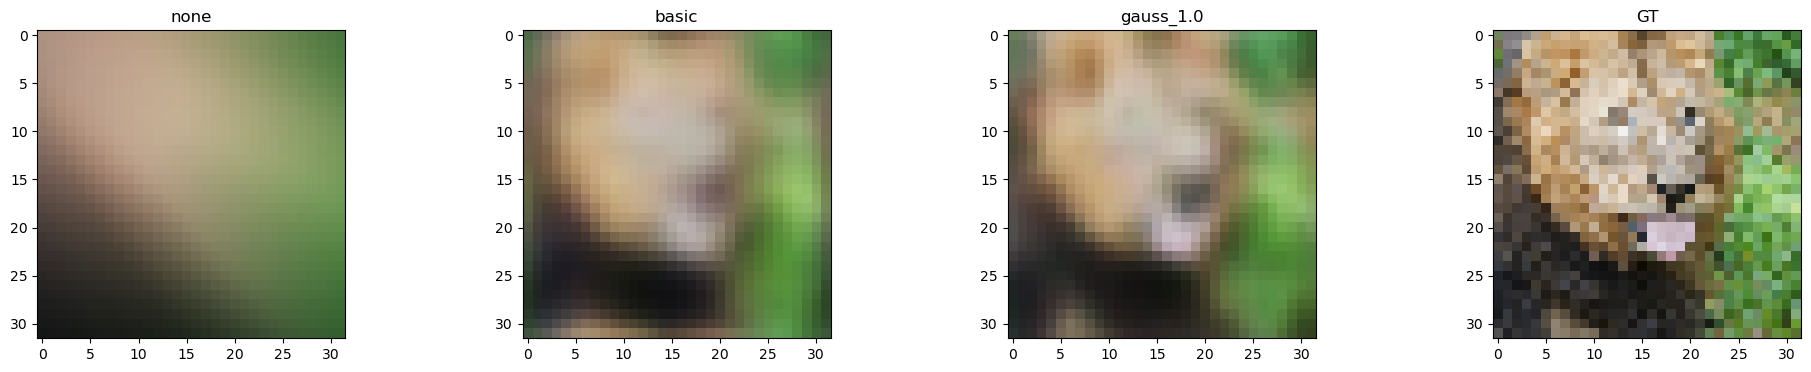

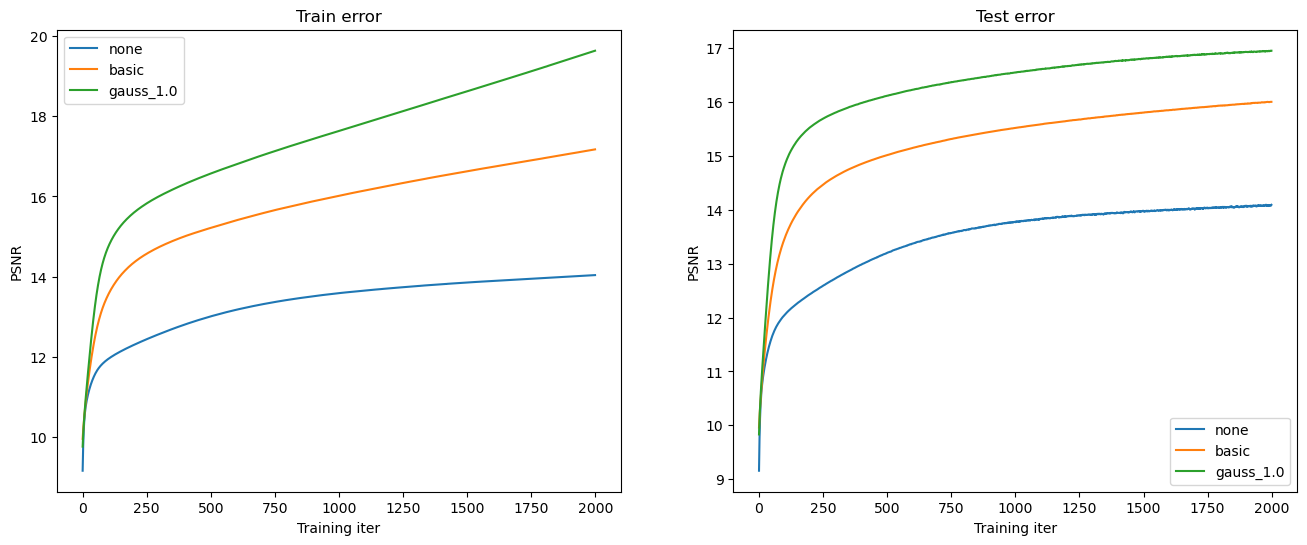

In [ ]:
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

# High Resolution Reconstruction

#### High Resolution Reconstruction - SGD - Various Input Mapping Stategies

Repeat the previous experiment, but at the higher resolution.

/tmp/ipykernel_1671925/2979632171.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


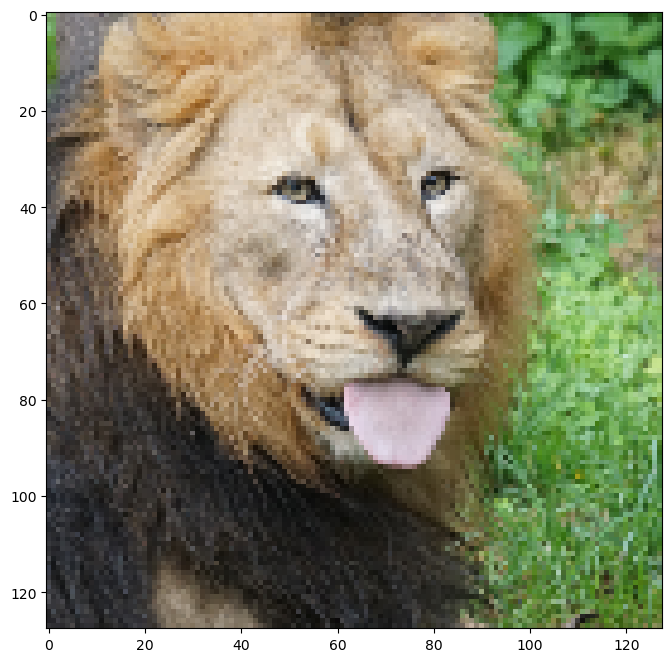

In [ ]:
# load hi-res image
size = 128
train_data, test_data = get_image(size)

In [ ]:
# Set the hyperparameters
num_layers = 4
output_size = 3

# Adjust these
hidden_size = 256
epochs = 300
learning_rate = 0.2

In [ ]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k,size, num_layers, hidden_size, output_size, epochs, learning_rate, 'mse', opt='SGD')

  0%|          | 0/3 [00:00<?, ?it/s]

training none


  0%|          | 0/300 [00:00<?, ?it/s]

training basic


  0%|          | 0/300 [00:00<?, ?it/s]

training gauss_1.0


  0%|          | 0/300 [00:00<?, ?it/s]

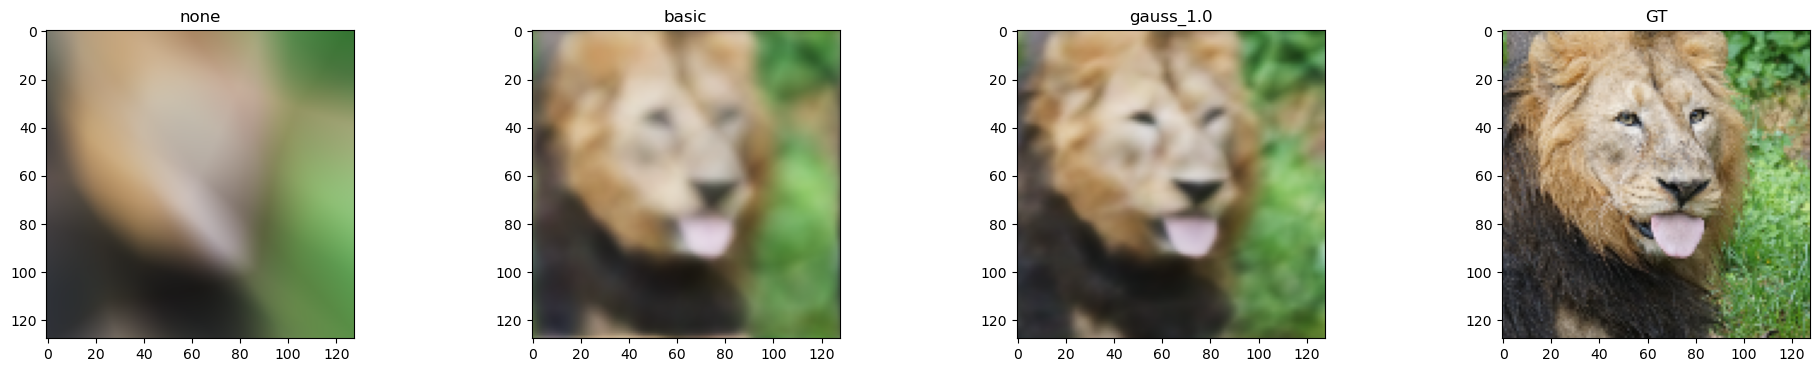

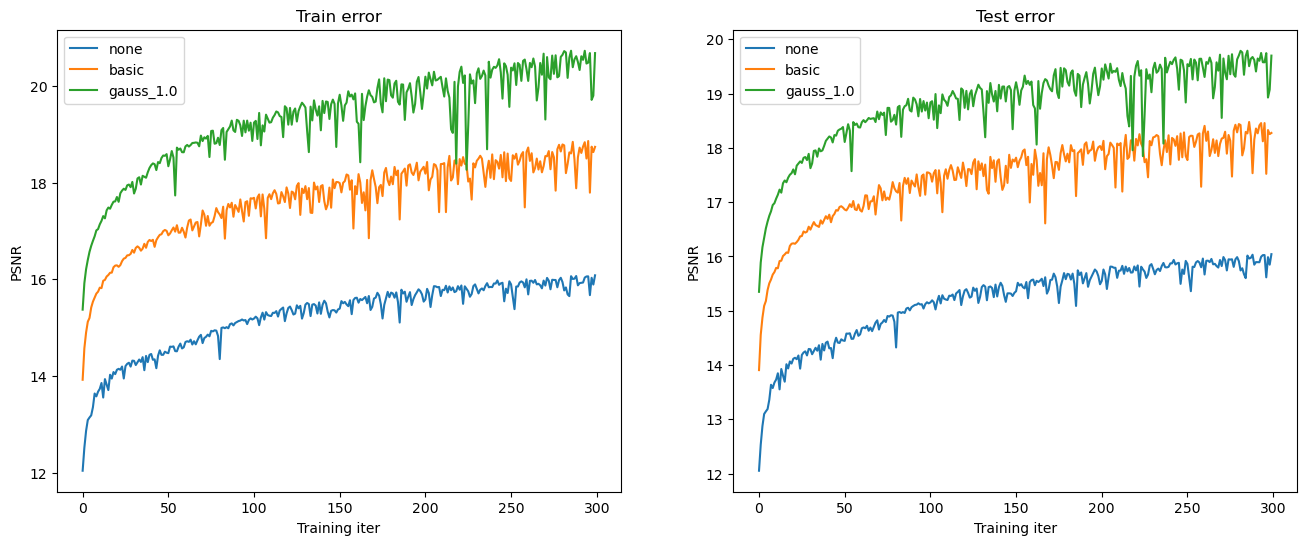

In [ ]:
X_train, y_train, X_test, y_test = get_input_features(get_B_dict(size), "none")  # for getting y_test

plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

#### High Resolution Reconstruction - Image of your Choice

/tmp/ipykernel_1671925/2979632171.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


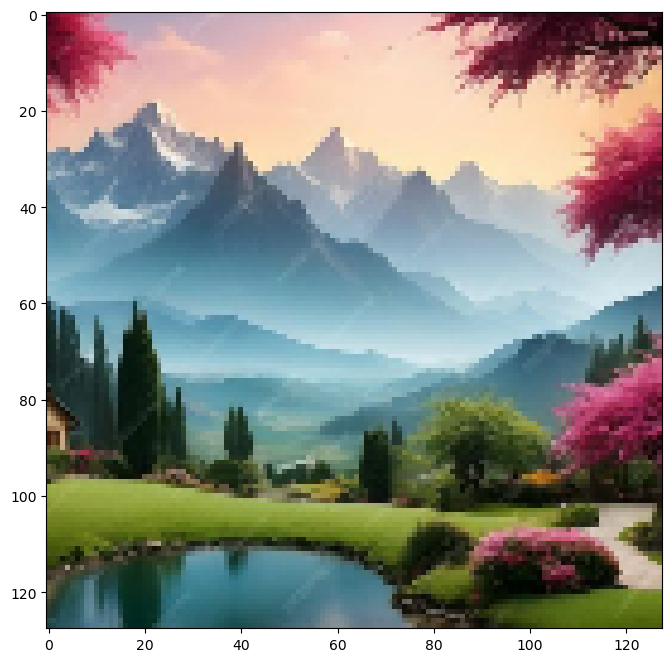

In [ ]:
size = 128

train_data, test_data = get_image(size, image_url="https://i.pinimg.com/736x/0c/b4/6f/0cb46fc064b18cede98279089d39e19b.jpg")

In [ ]:
# Set the hyperparameters
num_layers = 4
output_size = 3

# Adjust these
hidden_size = 256
epochs = 300
learning_rate = 0.2

  0%|          | 0/300 [00:00<?, ?it/s]

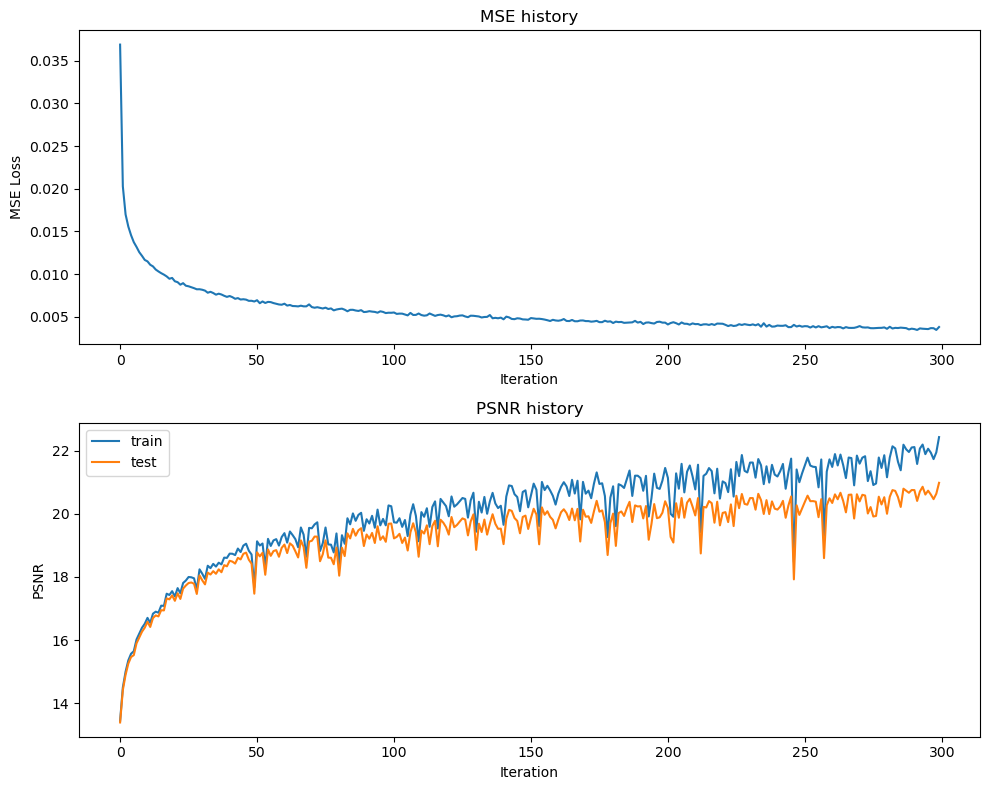

Final Test MSE 0.003990793849716292
Final Test psnr 20.97910710088206


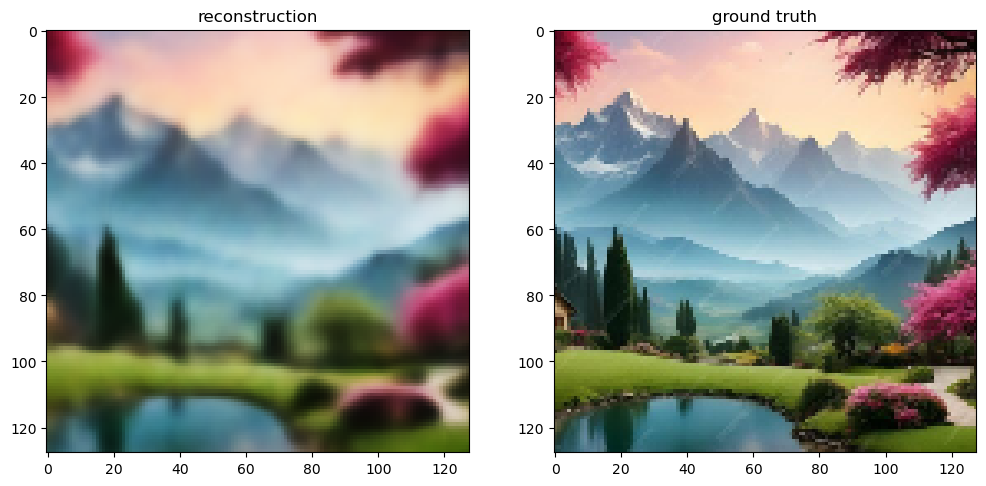

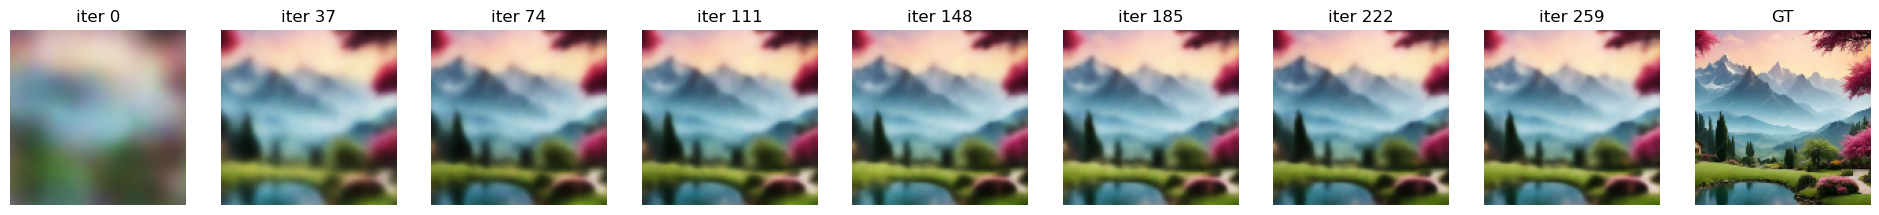

In [ ]:
# Get input features
B_dict = get_B_dict(size)
X_train, y_train, X_test, y_test = get_input_features(B_dict,mapping="gauss_1.0")
input_size = X_train.shape[1]

# Run NN experiment on input features
net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(
                    X_train, y_train, X_test, y_test, input_size, num_layers,
                    hidden_size, output_size, epochs, learning_rate, 'mse', opt="SGD",
                    batch_size=32)

# Plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

# 1. Additional Experiments - Adam Optimizer

#### Low Resolution Reconstruction - Adam - None Mapping

/tmp/ipykernel_1671925/2979632171.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


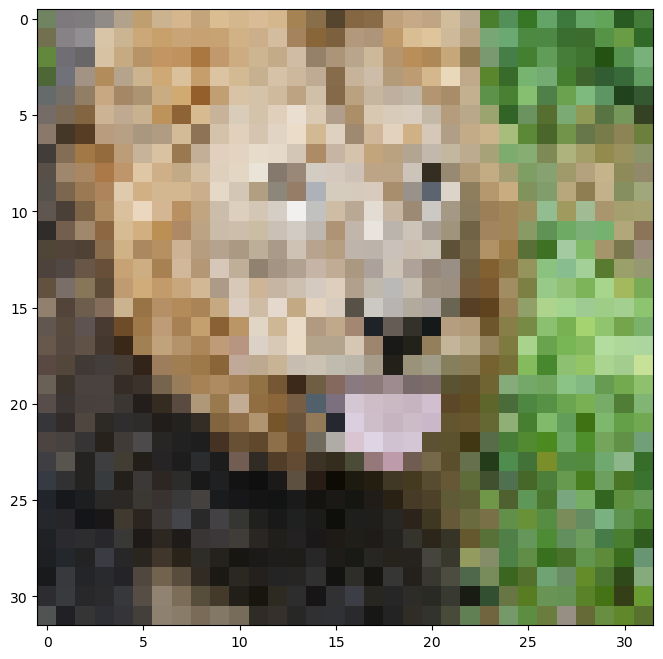

In [ ]:
# load low-res image
size = 32
train_data, test_data = get_image(size)

In [ ]:
# Set the hyperparameters
num_layers = 4
output_size = 3

# Adjust these
hidden_size = 256
epochs = 300
learning_rate = 0.0075

  0%|          | 0/300 [00:00<?, ?it/s]

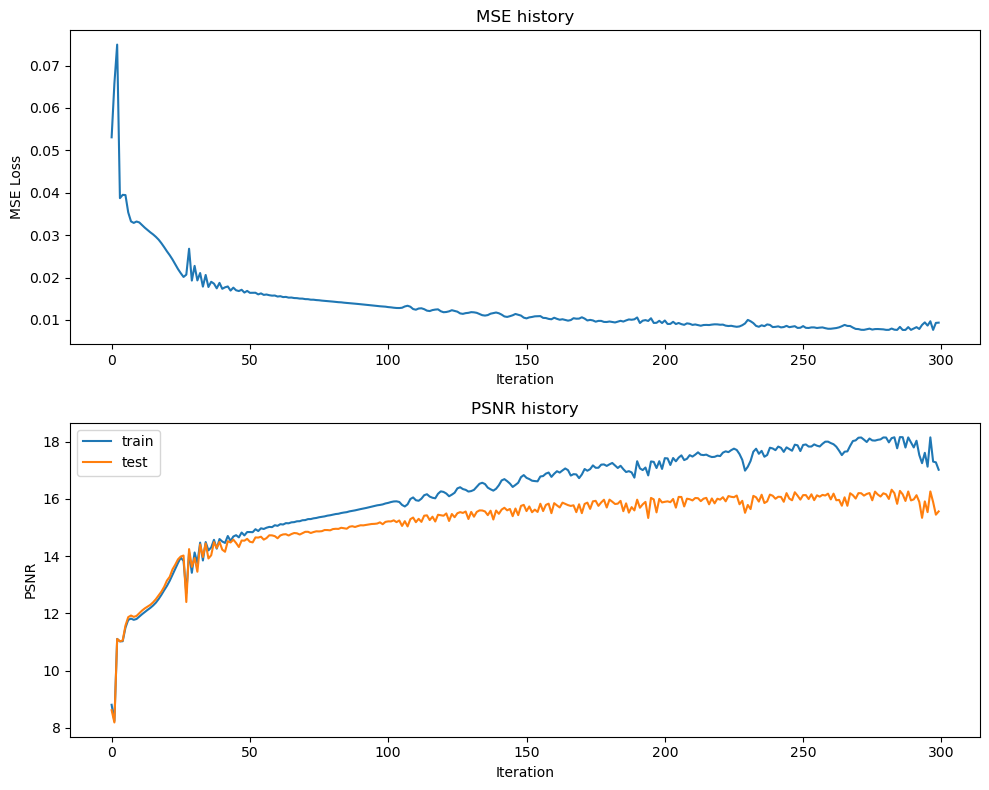

Final Test MSE 0.013894503187029448
Final Test psnr 15.56126981613346


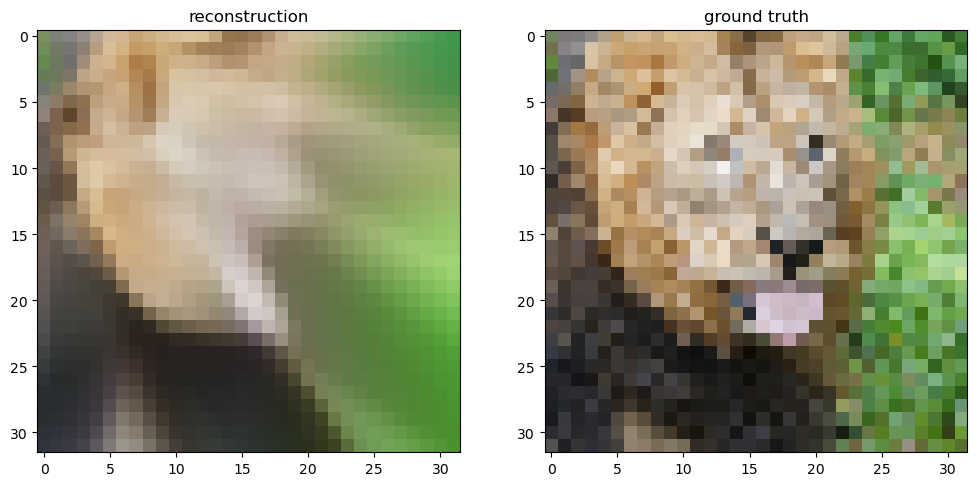

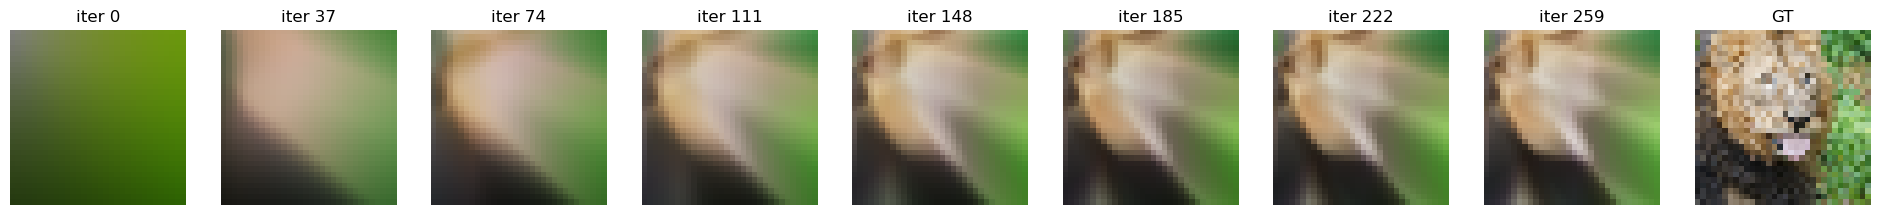

In [ ]:
# get input features
B_dict = get_B_dict(size)
X_train, y_train, X_test, y_test = get_input_features(B_dict,mapping='none')
input_size = X_train.shape[1]

# run NN experiment on input features
net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(
                    X_train, y_train, X_test, y_test, input_size, num_layers,
                    hidden_size, output_size, epochs, learning_rate, 'mse', opt="Adam",
                    b1=0.9, b2=0.999, eps=1e-8)

# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - Adam - Various Input Mapping Stategies

In [ ]:
# start training
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size, num_layers, hidden_size, output_size, epochs, learning_rate, 'mae', opt='Adam')

  0%|          | 0/3 [00:00<?, ?it/s]

training none


  0%|          | 0/300 [00:00<?, ?it/s]

training basic


  0%|          | 0/300 [00:00<?, ?it/s]

training gauss_1.0


  0%|          | 0/300 [00:00<?, ?it/s]

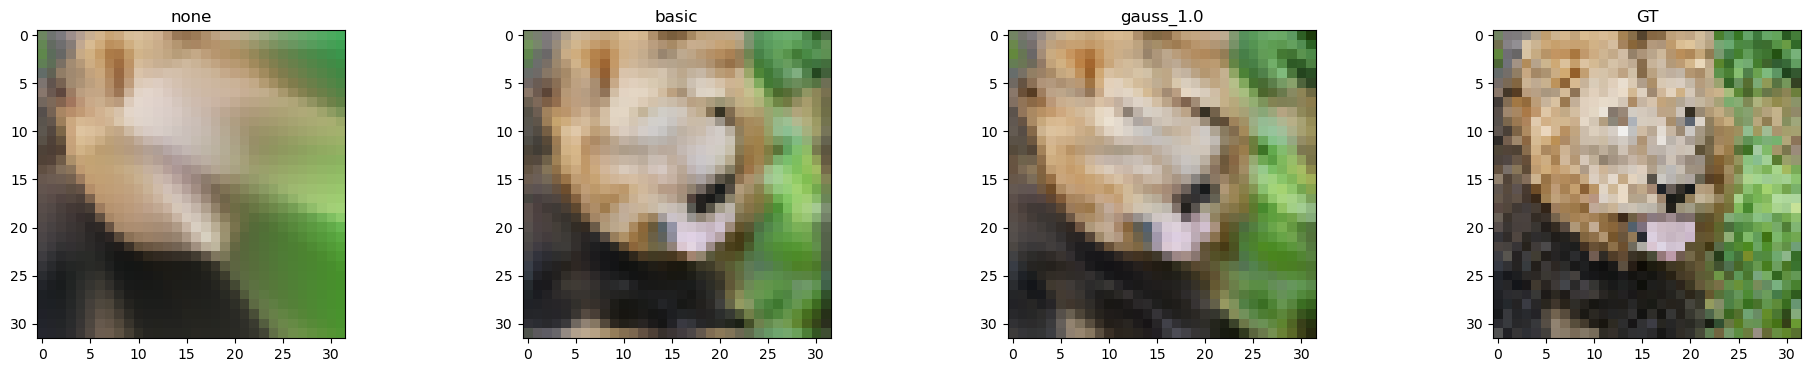

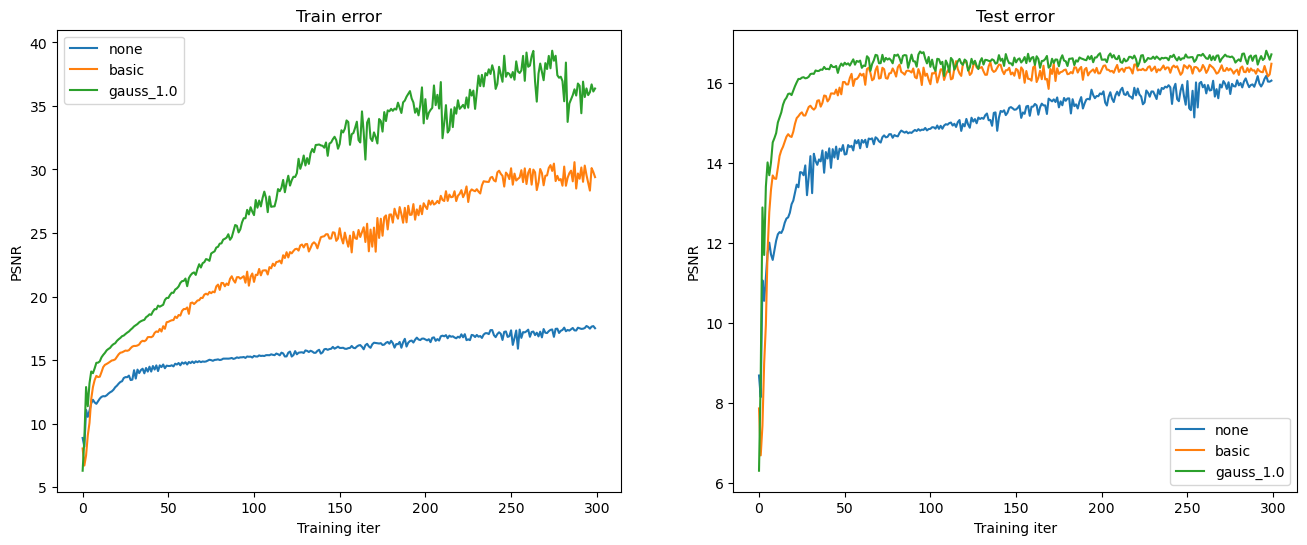

In [ ]:
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

#### High Resolution Reconstruction - Adam - Various Input Mapping Stategies

/tmp/ipykernel_1671925/2979632171.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


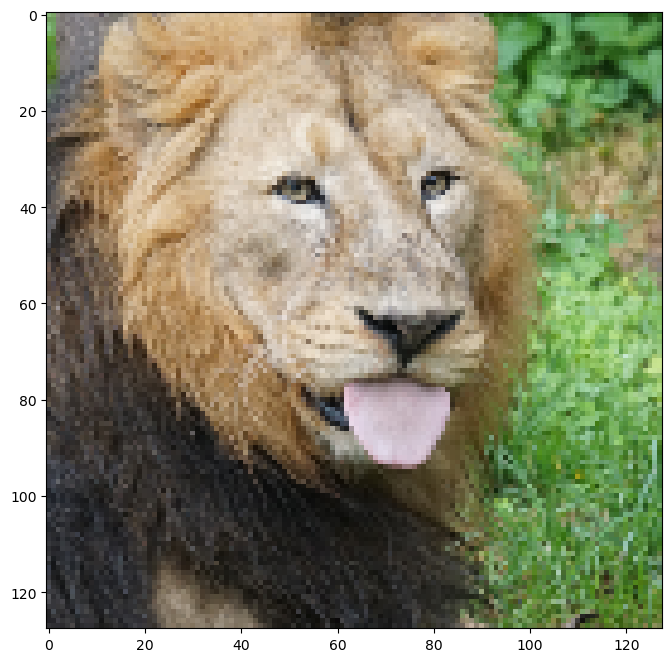

In [ ]:
# load hi-res image
size = 128
train_data, test_data = get_image(size)

In [ ]:
# Set the hyperparameters
num_layers = 4
output_size = 3

# Adjust these
hidden_size = 256
epochs = 300
learning_rate = 0.0075

In [ ]:
# start training
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size, num_layers, hidden_size, output_size, epochs, learning_rate, 'mse', opt='Adam')

  0%|          | 0/3 [00:00<?, ?it/s]

training none


  0%|          | 0/300 [00:00<?, ?it/s]

training basic


  0%|          | 0/300 [00:00<?, ?it/s]

training gauss_1.0


  0%|          | 0/300 [00:00<?, ?it/s]

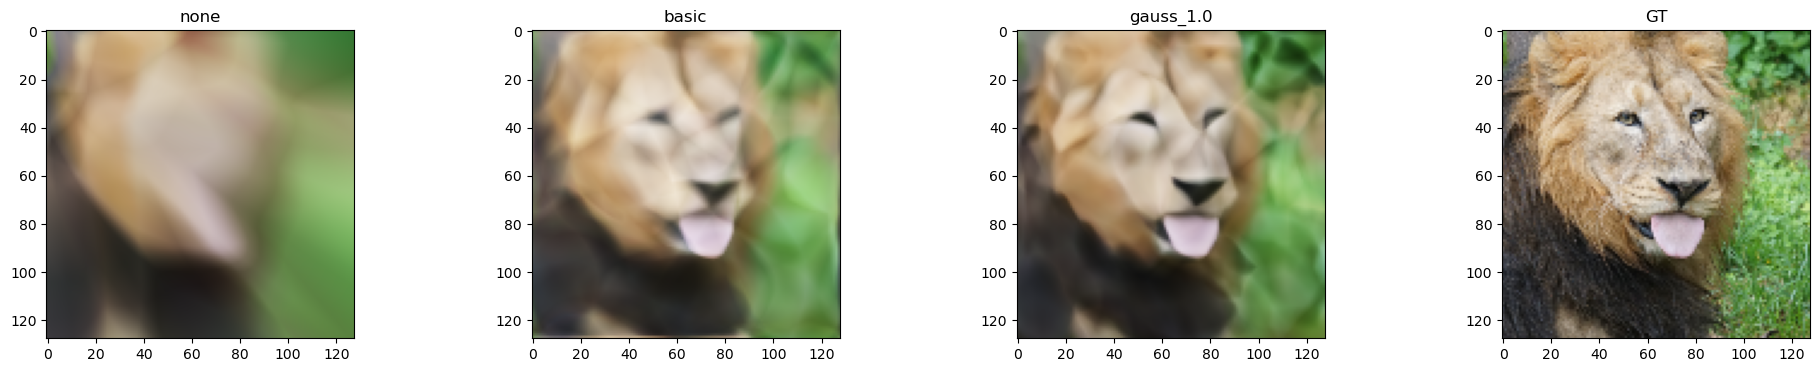

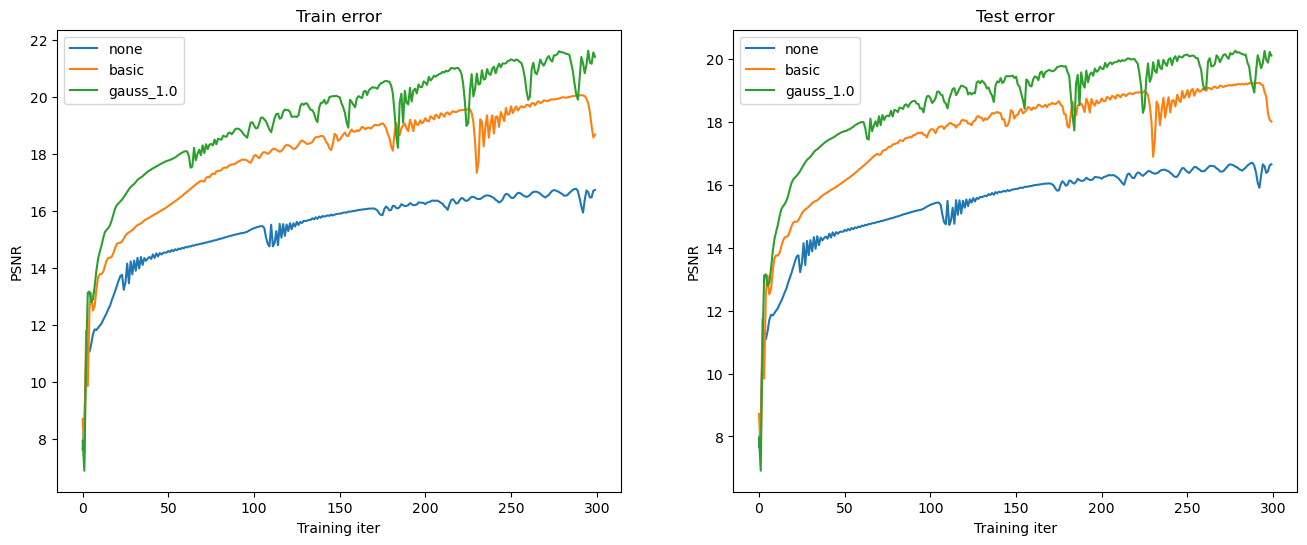

In [ ]:
X_train, y_train, X_test, y_test = get_input_features(get_B_dict(size), "none")  # for getting y_test

plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

# 2. Additional Experiments - Deeper Network

Low Resolution Reconstruction

/tmp/ipykernel_1671925/2979632171.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


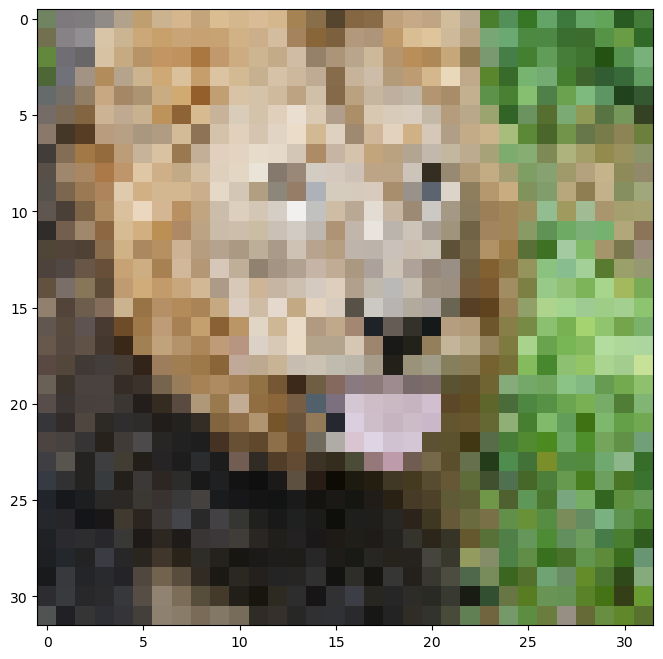

In [ ]:
size = 32
train_data, test_data = get_image(size)

In [ ]:
num_layers = 6
output_size = 3

hidden_size = 512
epochs = 300
learning_rate = 0.2

In [ ]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size, num_layers, hidden_size, output_size, epochs, learning_rate, 'mse', opt='SGD')

  0%|          | 0/3 [00:00<?, ?it/s]

training none


  0%|          | 0/300 [00:00<?, ?it/s]

training basic


  0%|          | 0/300 [00:00<?, ?it/s]

training gauss_1.0


  0%|          | 0/300 [00:00<?, ?it/s]

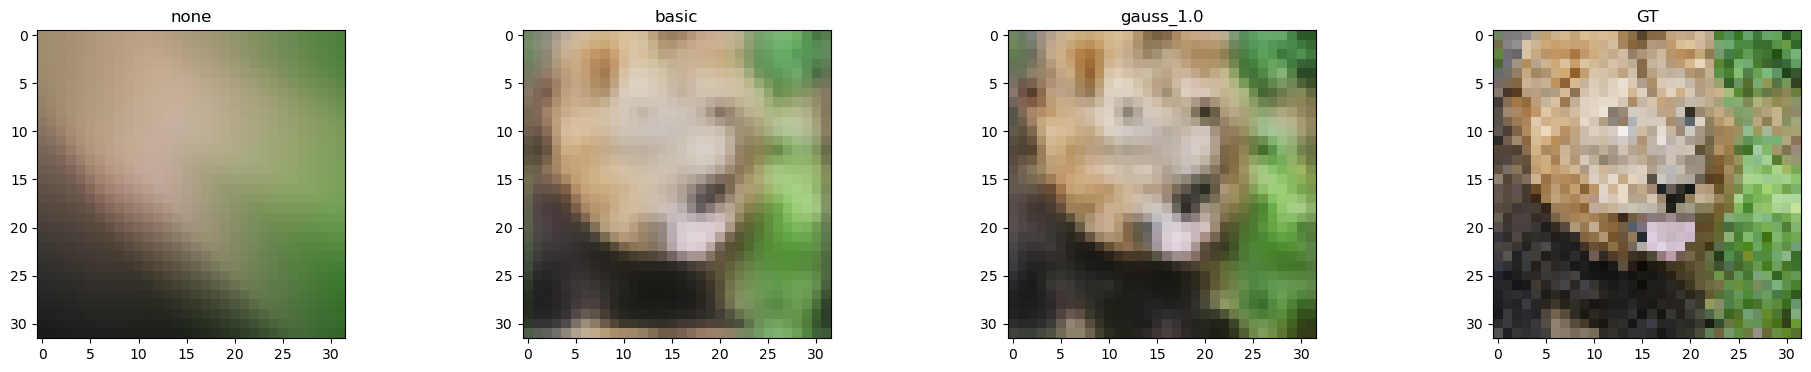

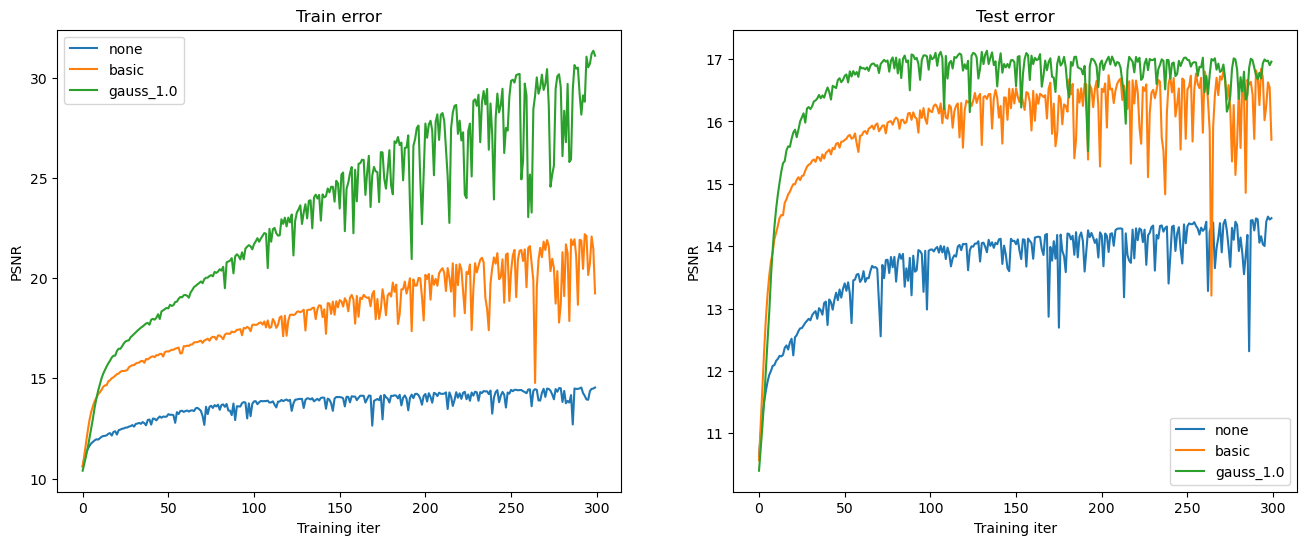

In [ ]:
X_train, y_train, X_test, y_test = get_input_features(get_B_dict(size), "none")  # for getting y_test

plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

High Resolution Reconstruction

/tmp/ipykernel_1671925/2979632171.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


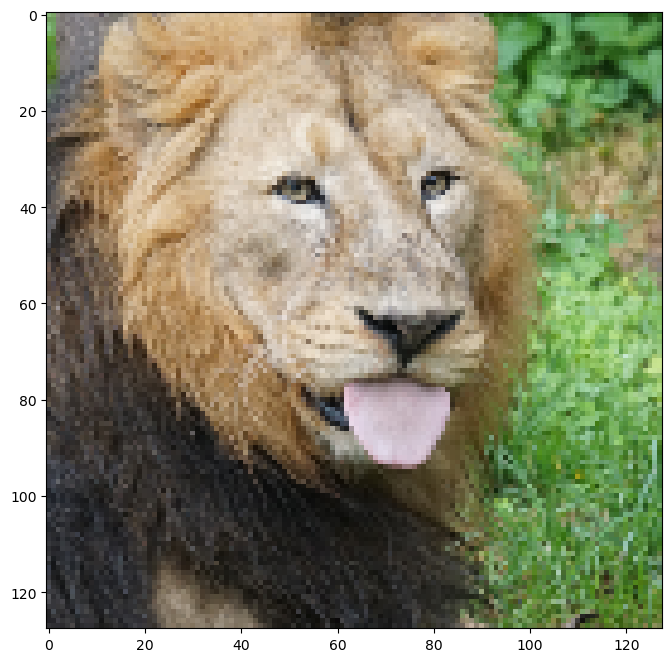

In [ ]:
size = 128
train_data, test_data = get_image(size)

In [ ]:
num_layers = 6
output_size = 3

# Adjust these
hidden_size = 768
epochs = 300
learning_rate = 0.2

In [ ]:
outputs = {}
B_dict = get_B_dict(size)
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size, num_layers, hidden_size, output_size, epochs, learning_rate, 'mse', opt='SGD')

  0%|          | 0/3 [00:00<?, ?it/s]

training none


  0%|          | 0/300 [00:00<?, ?it/s]

training basic


  0%|          | 0/300 [00:00<?, ?it/s]

training gauss_1.0


  0%|          | 0/300 [00:00<?, ?it/s]

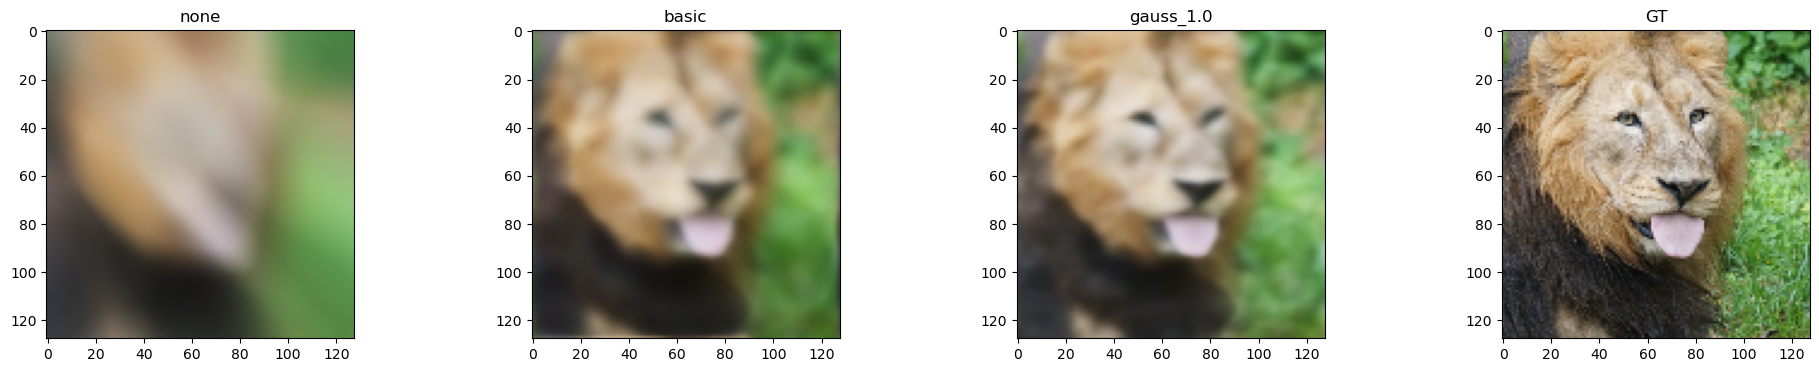

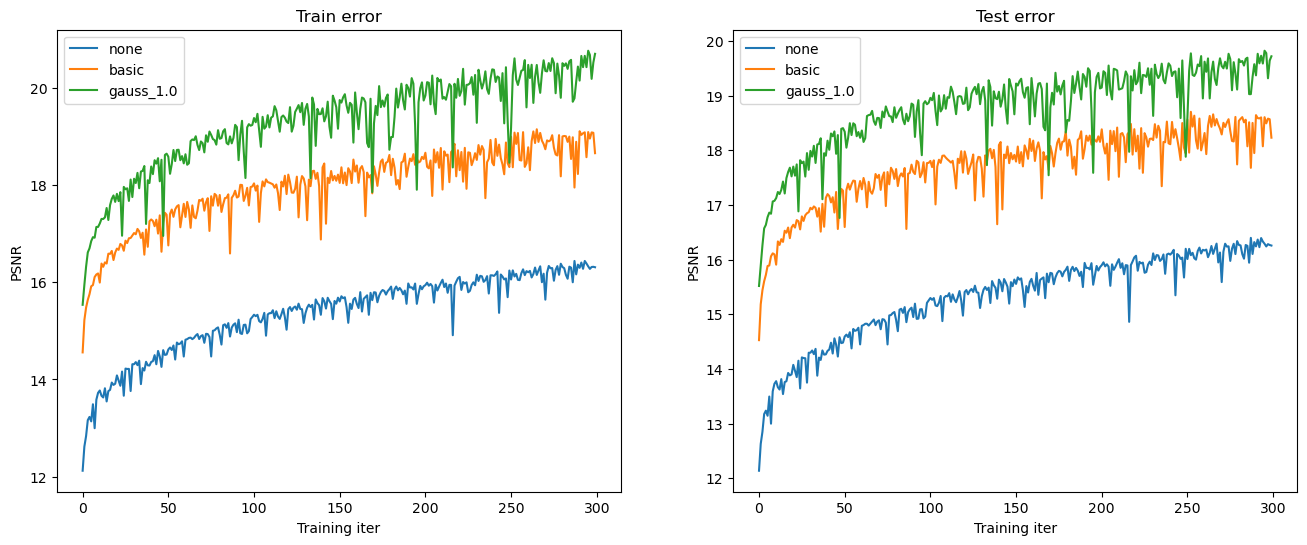

In [ ]:
X_train, y_train, X_test, y_test = get_input_features(get_B_dict(size), "none")
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

# 3. Additional Experiments - Alternative Losses

/tmp/ipykernel_1671925/2979632171.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


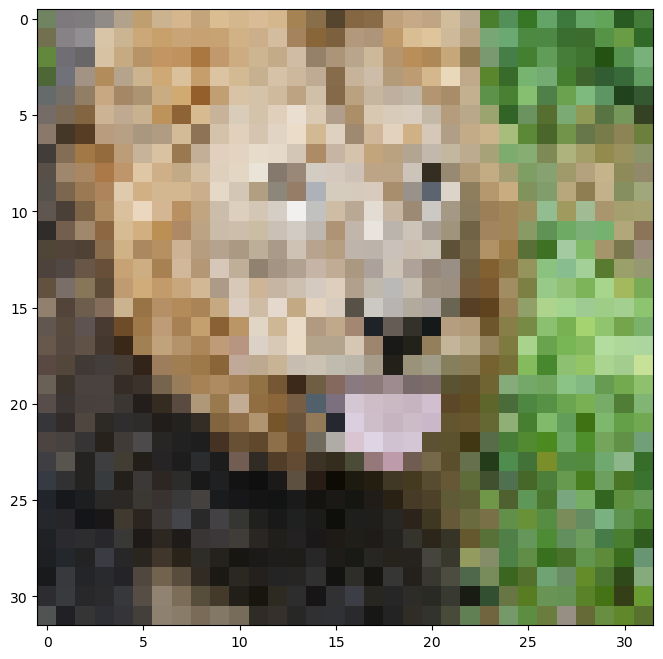

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
size = 32
train_data, test_data = get_image(size)
num_layers = 3
output_size = 3
hidden_size = 256
epochs = 300
learning_rate = 0.2


outputs = {}
B_dict = get_B_dict(size=256)
k = 'gauss_1.0'

## mae
outputs['mae'] = train_wrapper(k, size, num_layers, hidden_size, output_size, epochs, learning_rate, 'mae', opt='SGD')
outputs['mse'] = train_wrapper(k, size, num_layers, hidden_size, output_size, epochs, learning_rate, 'mse', opt='SGD')
outputs['huber'] = train_wrapper(k, size, num_layers, hidden_size, output_size, epochs, learning_rate, 'huber', opt='SGD')

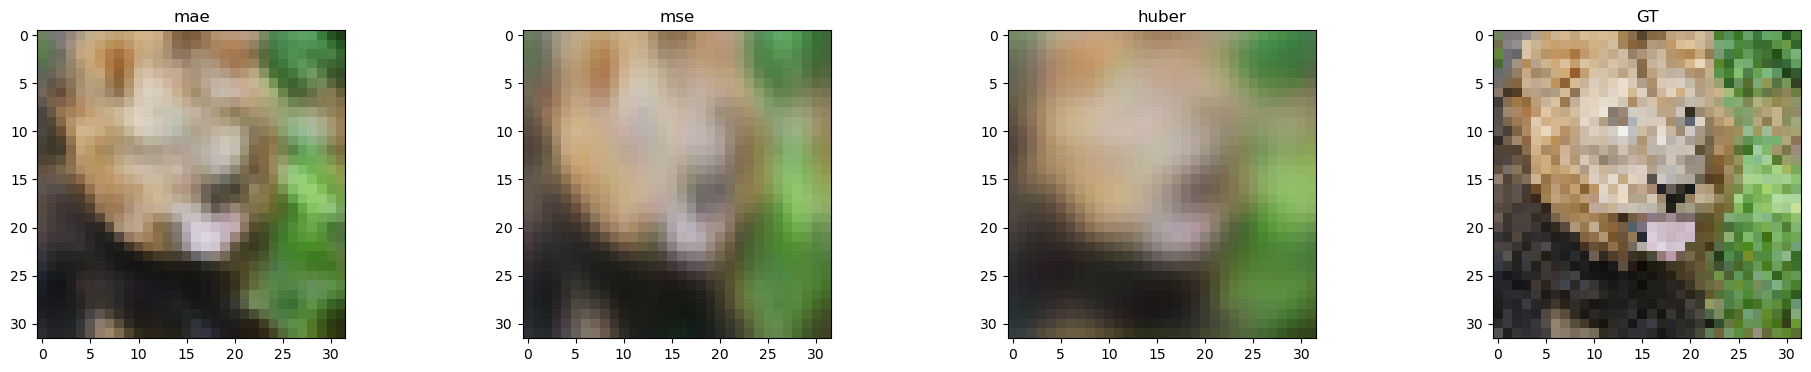

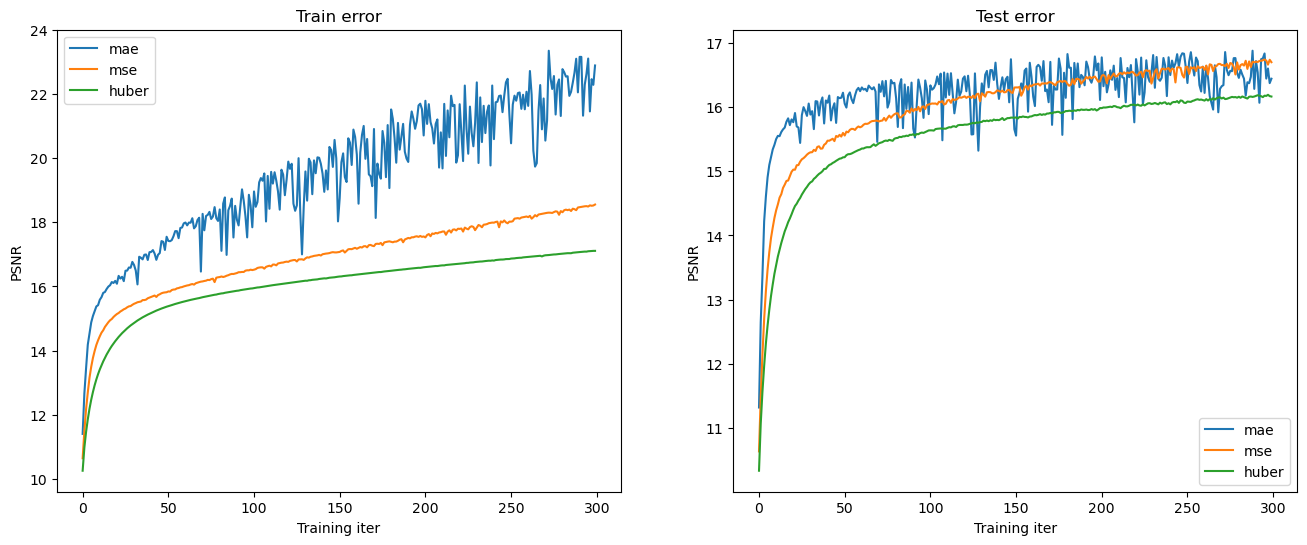

In [ ]:
X_train, y_train, X_test, y_test = get_input_features(get_B_dict(size), "none")
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

# 4. Additional Experiments - Gaussian Fourier Feature mapping hyperparameters

For mapping size: 1


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

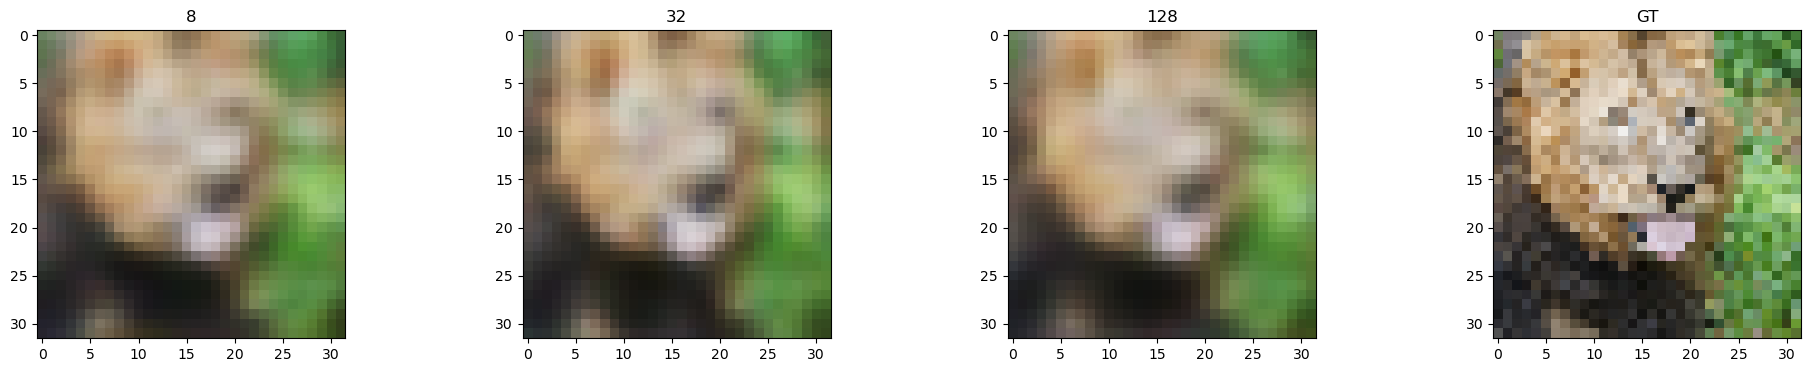

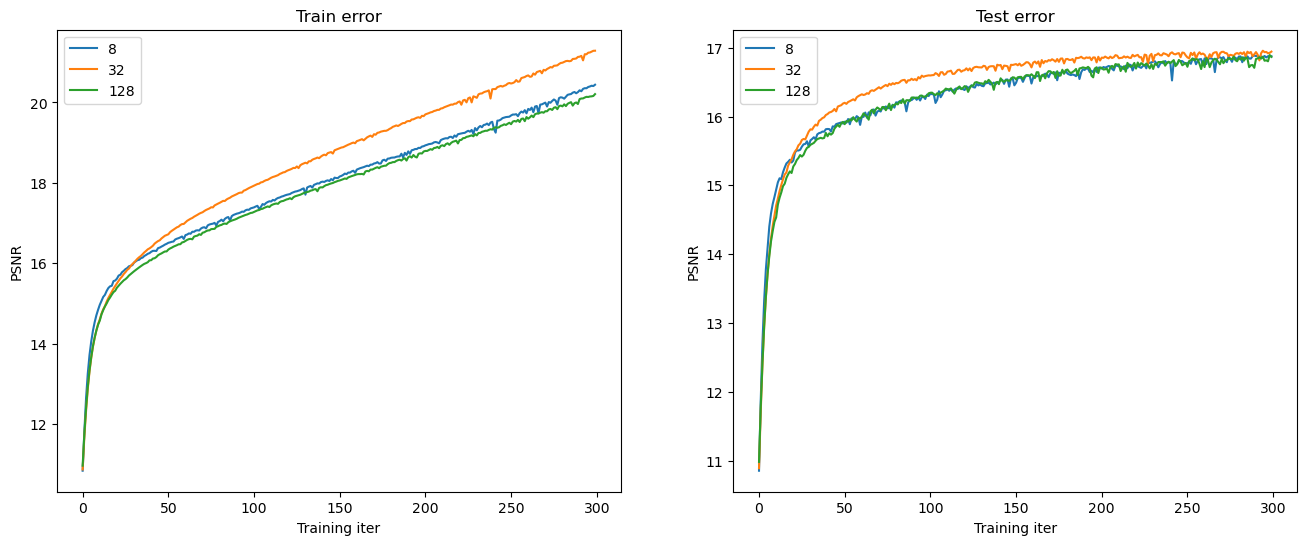

For mapping size: 2


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

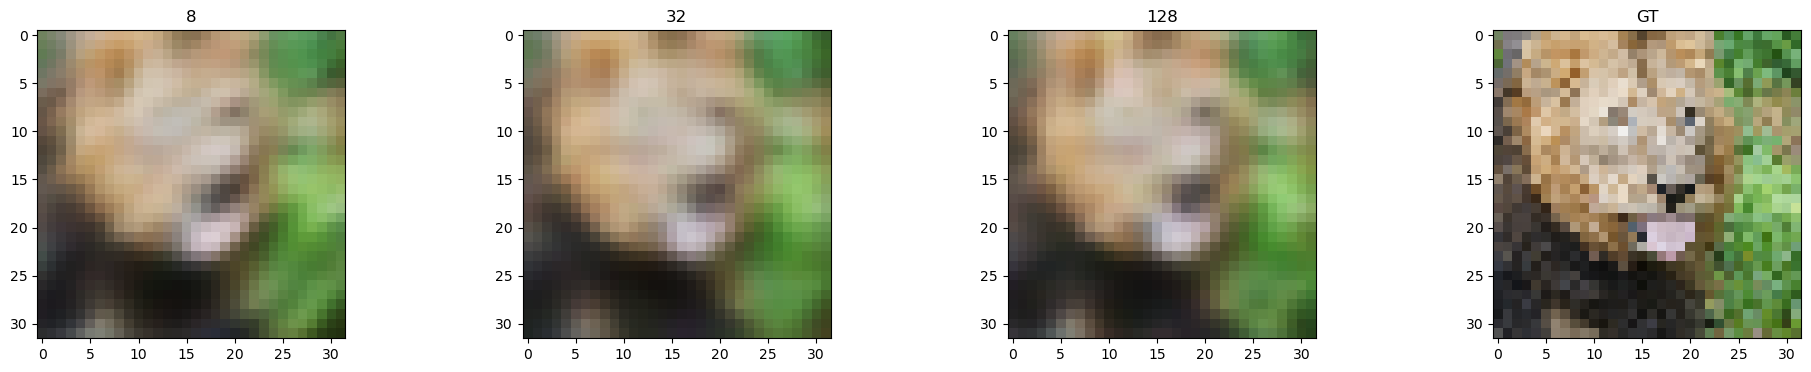

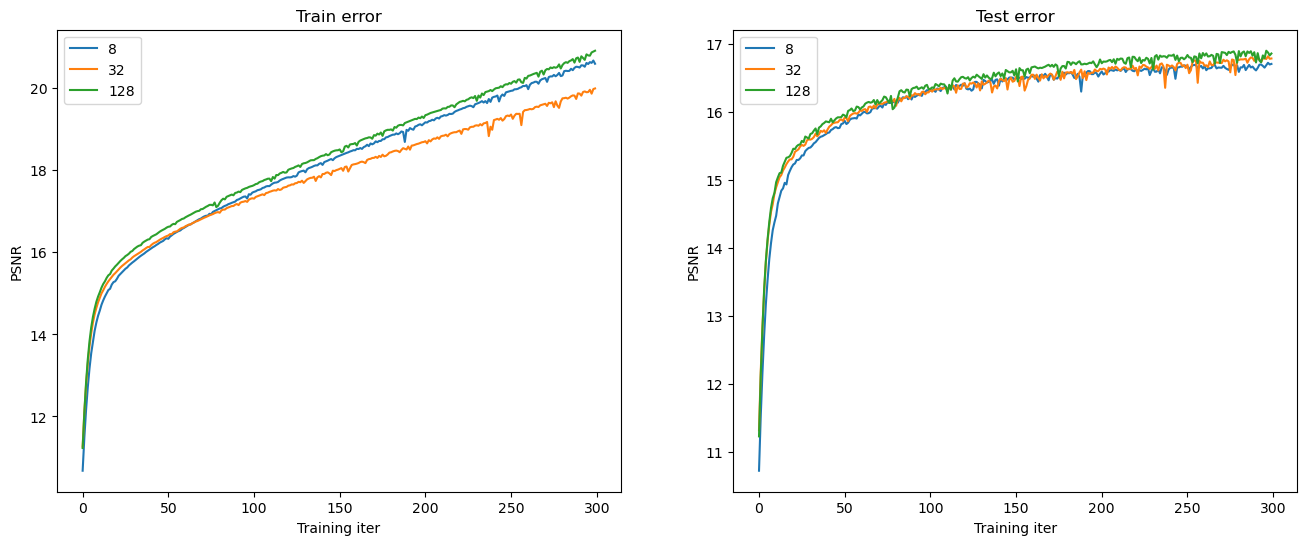

In [ ]:
mapping_sizes = [8, 32, 128]
gaussian_scales = [1, 2]

size = 32

hyperparameter_configs = []
for scale in gaussian_scales:
    outputs = {}
    print('For mapping size:', scale)
    for m_size in mapping_sizes:
        B_dict = get_B_dict(scale, m_size)
        outputs[m_size] = train_wrapper('gauss_1.0', size, num_layers, hidden_size, output_size, epochs, learning_rate, 'mse', opt='SGD')

    X_train, y_train, X_test, y_test = get_input_features(get_B_dict(size), "none")
    plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))


# 5. Additional Experiments - Image inpainting or restoration scenarios

/tmp/ipykernel_1671925/2979632171.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


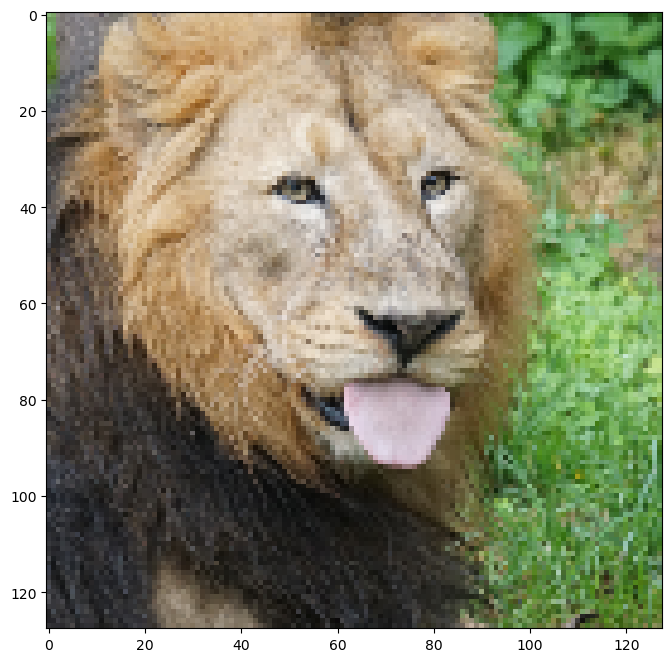

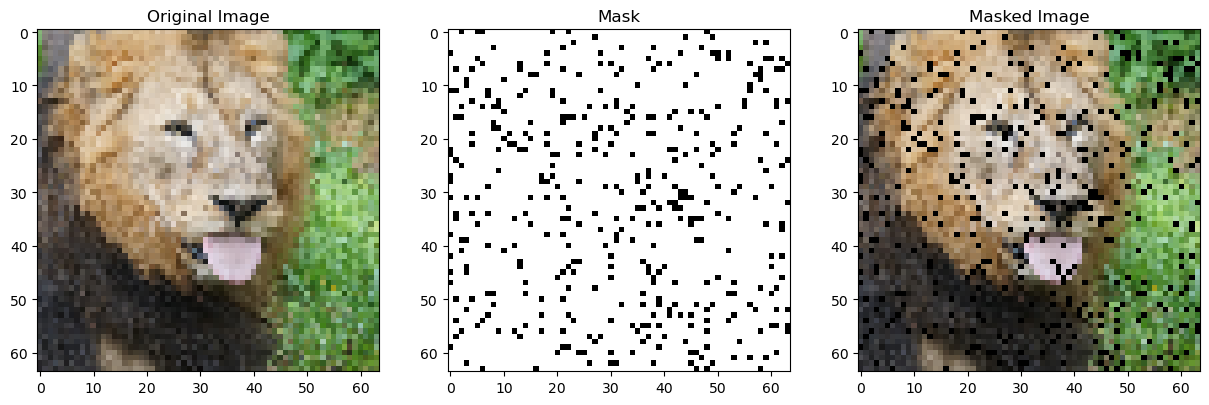

In [ ]:
size = 128
def get_inpainting_data(size=512, mask_type='random', mask_ratio=0.1):

    train_data_orig, test_data = get_image(size)
    train_coords, train_img = train_data_orig
    test_coords, test_img = test_data

    train_size = train_img.shape[0]  # Size of downsampled training image
    mask = np.ones((train_size, train_size), dtype=np.float32)

    if mask_type == 'random':
        random_mask = np.random.random((train_size, train_size)) > mask_ratio
        mask = random_mask.astype(np.float32)

    elif mask_type == 'center':
        center = train_size // 2
        radius = int(train_size * np.sqrt(mask_ratio) / 2)
        y, x = np.ogrid[:train_size, :train_size]
        center_mask = (x - center)**2 + (y - center)**2 <= radius**2
        mask[center_mask] = 0.0

    elif mask_type == 'checkerboard':
        block_size = max(1, int(train_size * np.sqrt(mask_ratio) / 4))
        for i in range(0, train_size, block_size*2):
            for j in range(0, train_size, block_size*2):
                if i + block_size <= train_size and j + block_size <= train_size:
                    mask[i:i+block_size, j:j+block_size] = 0.0

                if i + block_size*2 <= train_size and j + block_size*2 <= train_size:
                    mask[i+block_size:i+block_size*2, j+block_size:j+block_size*2] = 0.0


    mask_3c = np.stack([mask] * 3, axis=-1)
    masked_img = train_img * mask_3c

    train_gt = train_img.copy()

    inpainting_train_data = [train_coords, masked_img, mask_3c]


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(train_gt)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(masked_img)
    plt.title('Masked Image')
    plt.show()

    return inpainting_train_data, test_data, train_gt


train_data, test_data, train_gt = get_inpainting_data(size)

In [ ]:
num_layers = 4
output_size = 3

hidden_size = 256
epochs = 200
learning_rate = 0.2

  0%|          | 0/200 [00:00<?, ?it/s]

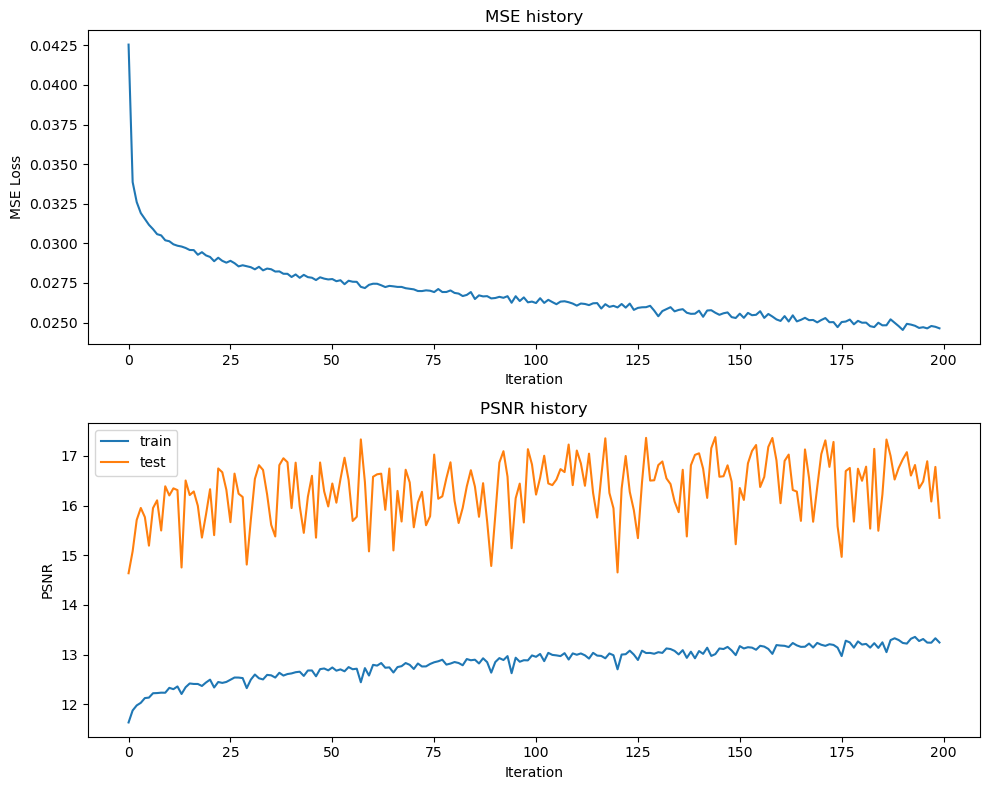

Final Test MSE 0.013294226003214523
Final Test psnr 15.753069467841119


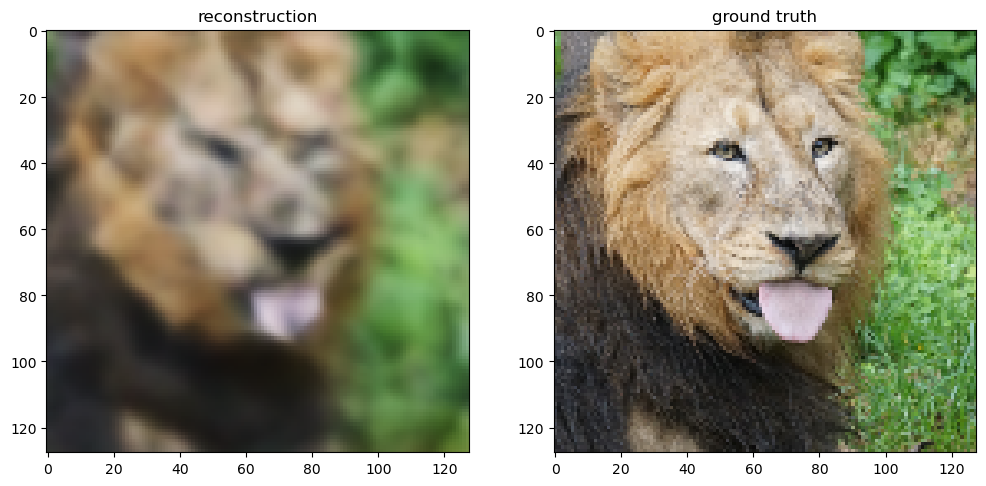

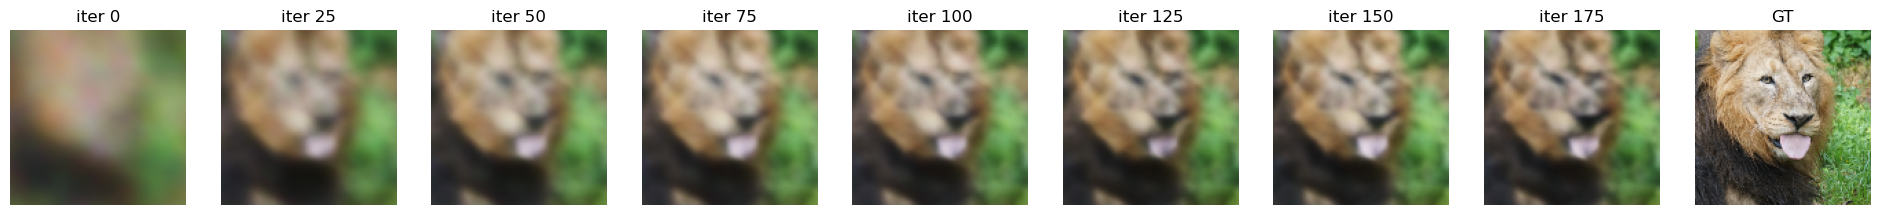

In [ ]:
B_dict = get_B_dict(size)
X_train, y_train, X_test, y_test = get_input_features(B_dict,mapping="gauss_1.0")
input_size = X_train.shape[1]

net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(
                    X_train, y_train, X_test, y_test, input_size, num_layers,
                    hidden_size, output_size, epochs, learning_rate, 'mse', opt="SGD",
                    batch_size=32)


plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)